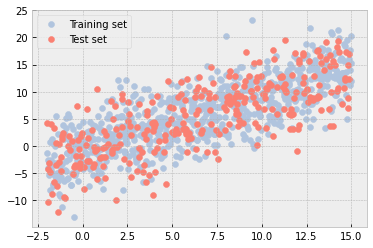

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import normal
plt.style.use('bmh')
%matplotlib inline

np.random.seed(3)

x = np.linspace(start = -2, stop=15, num=1000)
intercept, x_coef = -1, 1 
y = [x_coef*i + intercept for i in x]
y = [i+normal(0, 4) for i in y]

data = pd.DataFrame({'x': x, 'y': y})

# Split the data into training/testing sets
train, test = train_test_split(data, test_size=0.3)
X_train, X_test = train.x, test.x

# Split the targets into training/testing sets
y_train, y_test = train.y, test.y

plt.scatter(X_train, y_train, color='lightsteelblue', label = 'Training set')
plt.scatter(X_test, y_test, color='salmon', label = 'Test set')
plt.legend()

In [2]:
import mxnet as mx
from mxnet import nd, autograd, gluon


model_ctx=mx.cpu()
par={'weights':nd.random_normal(shape=1,ctx=model_ctx),'bias':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx)}

In [3]:
import sys
sys.path.append("../") 

# No Uncertainty

In [4]:
from hamiltonian.inference.bbb import bbb
from hamiltonian.models.linear import linear

par_aleatoric={'weights':nd.random_normal(shape=1,ctx=model_ctx),
     'bias':nd.random_normal(shape=1,ctx=model_ctx),
     'weights_scale':nd.random_normal(shape=1,ctx=model_ctx),
     'bias_scale':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx)}
model=linear(hyper,ctx=model_ctx)
inference=bbb(model,par_aleatoric,step_size=0.05,ctx=model_ctx)

In [5]:
import numpy as np

X_train_tensor=X_train.values[:,np.newaxis]
y_train_tensor=y_train.values

In [6]:
par,loss=inference.fit(epochs=1000,batch_size=64,gamma=0.9,
                       X_train=X_train_tensor,y_train=y_train_tensor,verbose=False)

100%|██████████| 1000/1000 [02:19<00:00,  7.19it/s]


In [7]:
X_test_tensor=nd.array(X_test.values[:,np.newaxis],ctx=model_ctx)

In [8]:
y_pred=model.predict(par,X_test_tensor)
y_pred.mean.asnumpy()

array([ 2.3303514 ,  1.1438992 ,  1.8394058 ,  9.21723   ,  2.5621872 ,
        6.230643  ,  4.457783  ,  3.06677   ,  3.5168037 ,  8.27625   ,
        9.967285  ,  6.1760936 , 10.949178  , -1.3653792 ,  3.025858  ,
        1.4984711 ,  6.7215886 , -0.11074002,  1.8666804 ,  2.957671  ,
        0.47566742,  3.1485944 , -0.9971699 , 10.130935  ,  9.871824  ,
       -1.2426429 ,  7.348908  ,  1.3484598 , -0.9698951 , -0.49258673,
        6.4215665 ,  5.944258  ,  9.517252  ,  0.31201887,  6.380654  ,
        1.9075925 ,  9.721813  , -0.54713625,  6.707951  ,  5.7533345 ,
        2.2621646 ,  5.3714876 ,  0.46203005,  0.8029646 ,  3.8713756 ,
        5.766972  ,  3.7486393 , -0.8471587 ,  6.598852  , 11.6855955 ,
       10.294583  ,  8.38535   ,  7.0625234 ,  1.5802953 , 10.36277   ,
        7.089798  ,  8.658097  ,  4.512333  ,  6.762501  ,  4.4850583 ,
        2.6985607 ,  4.3895965 ,  8.753559  , 11.044639  , 11.2492    ,
       10.908265  ,  1.4302843 , -1.4472035 ,  6.435204  ,  4.10

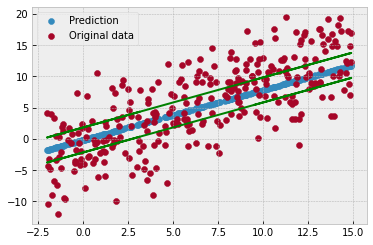

In [9]:
plt.scatter(X_test, y_pred.mean.asnumpy(), label = 'Prediction')
plt.plot(X_test,y_pred.mean.asnumpy()+2*y_pred.stddev,'g')
plt.plot(X_test,y_pred.mean.asnumpy()-2*y_pred.stddev,'g')
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

# Aleatoric Uncertainty

In [10]:
par_aleatoric={'weights':nd.random_normal(shape=1,ctx=model_ctx),
     'bias':nd.random_normal(shape=1,ctx=model_ctx),
     'weights_scale':nd.random_normal(shape=1,ctx=model_ctx),
     'bias_scale':nd.random_normal(shape=1,ctx=model_ctx)}
hyper={'alpha':nd.array(10.0, ctx=model_ctx)}

In [13]:
from hamiltonian.models.linear import linear_aleatoric

model=linear_aleatoric(hyper,ctx=model_ctx)
inference=sgd(model,par_aleatoric,step_size=0.05,ctx=model_ctx)

In [12]:
par_aleatoric,loss=inference.fit(epochs=1000,batch_size=64,gamma=0.0,
                                 X_train=X_train_tensor,y_train=y_train_tensor,verbose=True)

  0%|          | 1/1000 [00:00<02:25,  6.87it/s]


[78.17464]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[58.31625]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[57.622276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[35.494568]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[26.95729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[18.274765]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[11.649608]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.633291]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.372388]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[13.327088]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.4569

[13.227652]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[16.504421]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[21.758156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[20.715948]
<NDArray 1 @cpu(0)>
<class 'm

  0%|          | 2/1000 [00:00<02:40,  6.21it/s]


[26.631002]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[22.421532]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[23.44171]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[16.410545]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[13.061279]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[11.307881]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.575207]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.244697]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3862205]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.496453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.269044]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[12.0118885]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[12.089493]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[14.214722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarra

  0%|          | 4/1000 [00:00<02:18,  7.20it/s]


[12.410719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.352189]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[11.82309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.548882]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.4775167]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.6247015]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.068586]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[11.098813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.564195]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.31513]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.530266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.913977]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.105962]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.419412]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndar

  1%|          | 7/1000 [00:00<01:36, 10.27it/s]


[9.29323]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.809461]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.196236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.817014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.706392]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.63717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.389705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.0108924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.472538]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.602787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.153968]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.088703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.42128]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.917618]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

  1%|          | 9/1000 [00:01<01:32, 10.67it/s]


[7.287112]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.660635]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.01502]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.233403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.13587]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.80706]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.676213]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.4128547]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.029627]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.757184]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2814894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5844345]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.014813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.179179]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

  1%|          | 11/1000 [00:01<01:30, 10.88it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.713456]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2626534]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.60392]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.024149]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.131117]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.034572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.772256]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.65403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.281626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.864826]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7116423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2577486]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.600948]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.030135]
<NDArray 

  1%|▏         | 13/1000 [00:01<01:33, 10.59it/s]


[8.997515]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761315]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.650711]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.2392497]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.813405]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7012725]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2537456]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.605767]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.036302]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[10.095652]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.971712]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.756378]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.646356]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.2241697]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarr

  2%|▏         | 17/1000 [00:01<01:20, 12.17it/s]


[6.180599]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.738493]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.691498]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.243397]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.582723]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.050981]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.997675]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.902093]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.742819]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.637113]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.1635466]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.716128]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6892304]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2408624]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

  2%|▏         | 19/1000 [00:01<01:23, 11.74it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.06247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.94365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.858879]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.735274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.632764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.1264024]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.667966]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6840186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.237074]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.568241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.06835]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.916913]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.839028]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.73219]
<NDArray 1 @c

  2%|▏         | 23/1000 [00:02<01:13, 13.23it/s]


[6.0933466]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.624672]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6804566]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2345996]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.56082]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.080685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.868844]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.800873]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.726655]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.628183]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.077834]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.604351]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.679154]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2337966]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

  2%|▎         | 25/1000 [00:02<01:18, 12.49it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6772118]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.232975]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.551336]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.099743]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.802803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.749238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7203865]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.625674]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.034894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.5477085]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.676606]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2329082]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5486355]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.1062]
<NDArray

  3%|▎         | 27/1000 [00:02<01:15, 12.85it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2330494]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.546189]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.112691]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762939]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.718014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.717309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.62493]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.009106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.51347]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.67597]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2333794]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.543915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.119195]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.744118]
<NDArray 1 @

  3%|▎         | 31/1000 [00:02<01:09, 13.98it/s]


[9.70859]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.675487]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.714064]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.624931]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.974238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.466863]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.67631]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2353544]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.138703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.691807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.662363]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.713297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.625184]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

  3%|▎         | 33/1000 [00:02<01:13, 13.12it/s]


[7.2373548]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535063]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.151609]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.660084]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.637562]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.712168]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.626006]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.9433947]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.425305]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.677879]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.238524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.533721]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.158009]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.645091]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

  4%|▎         | 37/1000 [00:03<01:09, 13.82it/s]


[6.67946]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.241147]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.531395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.170668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.616722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.603686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.711346]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.627902]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.916066]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.388193]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6803827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.242582]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.530396]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.176915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

  4%|▍         | 39/1000 [00:03<01:20, 11.88it/s]


[9.365658]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6824517]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2456565]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5286875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.189224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.577897]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.573381]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.711369]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.630413]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.89181]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.354999]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.683583]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.24728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5279665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

  4%|▍         | 41/1000 [00:03<01:15, 12.77it/s]


[5.8843403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.344723]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.684769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.248953]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.527326]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.201257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.554272]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.554954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.711758]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.632343]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.877156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.334816]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.686004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2506666]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

  4%|▍         | 45/1000 [00:03<01:08, 13.88it/s]


[7.2541976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.525832]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.218729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.521871]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.529699]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.712785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.635519]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.8571973]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.307161]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.689949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.256004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.525461]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.224389]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.511817]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

  5%|▍         | 47/1000 [00:03<01:13, 12.96it/s]


[7.259673]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524882]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.235453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.492746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.507017]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.714225]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.638928]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.839403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.282327]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6941485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.261528]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.240853]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.483702]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

  5%|▌         | 51/1000 [00:04<01:08, 13.86it/s]


[5.8286123]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.267179]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.697035]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.265259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524368]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.251388]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.466533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.486616]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.715969]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.642477]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.8235126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2599945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.6984935]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.267128]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

  5%|▌         | 53/1000 [00:04<01:14, 12.75it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.246357]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7014275]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.27086]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524199]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.266509]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.442907]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.468245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.717928]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.64609]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.8093004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.239885]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.702898]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.272718]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524204]
<NDArray 1 

  6%|▌         | 55/1000 [00:04<01:12, 13.04it/s]



[7.2745667]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.276134]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.428454]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.457011]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.719316]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.648502]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.8006597]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2275915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.705832]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2764044]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.280809]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.421589]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarr

  6%|▌         | 59/1000 [00:04<01:08, 13.73it/s]


[6.708746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2800403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524483]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.289889]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.408533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.441537]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7214775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.652096]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.788819]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210658]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7101903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2818346]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.524605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.294294]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

  6%|▌         | 61/1000 [00:05<01:13, 12.82it/s]


[9.20029]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7130485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2853703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5249]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.302837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.390522]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.427555]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.723691]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.655622]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.778186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.195361]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.714459]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2871084]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.52507]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

  6%|▋         | 63/1000 [00:05<01:12, 13.00it/s]


[9.311029]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.379475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.418984]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.725177]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.657921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.771701]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.185985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7172375]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2905216]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.525448]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.314996]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.374219]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.414907]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.725919]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

  6%|▋         | 65/1000 [00:05<02:29,  6.26it/s]


[9.36421]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.407148]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.727394]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.661275]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.762787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.173037]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.721287]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


  7%|▋         | 67/1000 [00:06<02:20,  6.63it/s]


[7.2954707]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.52609]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.326388]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.359447]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.403455]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.728127]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.662366]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7600164]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.168997]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7226014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.2970724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.526319]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.330021]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.354836]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

  7%|▋         | 68/1000 [00:06<02:14,  6.94it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.723898]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.298649]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.526554]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.333572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.350371]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.396422]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.729578]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.664502]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.754753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.161304]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.725176]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3002005]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.526795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.337045]
<NDArray 1

  7%|▋         | 72/1000 [00:06<01:38,  9.47it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.527041]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.340438]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.341865]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.389832]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.731005]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.666576]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.749839]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.154097]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.727673]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3032265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.52729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.343755]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.337811]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.386693]
<NDArray 1 

  7%|▋         | 74/1000 [00:06<01:56,  7.96it/s]


[9.326404]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.37786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.733768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.670528]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.740955]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.141005]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7324276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3089657]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.528315]
<NDArray 1 @cpu(0)>

  8%|▊         | 77/1000 [00:07<01:39,  9.29it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.356273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.322837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.375099]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.734438]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.671475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.738914]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.137985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7335653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.310335]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.528574]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.359221]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.319381]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.372425]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.735099]
<NDArray 1

  8%|▊         | 79/1000 [00:07<01:40,  9.20it/s]


[7.3129954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.529094]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.364912]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.312787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.367324]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.736393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.674212]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7331853]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.129484]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.736855]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3142867]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.529353]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.367656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.309643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

  8%|▊         | 81/1000 [00:07<01:29, 10.22it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7379103]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.315552]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.529612]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.370334]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.306596]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.3625345]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.737646]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.675954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.729668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.124248]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.738945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.316792]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.52987]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.372948]
<NDArray 1

  8%|▊         | 83/1000 [00:07<01:22, 11.08it/s]


[9.11933]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.740954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3191957]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.53038]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.377985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.298004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.355891]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.739452]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.678439]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7248077]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.116985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7419276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.32036]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.530633]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

  8%|▊         | 85/1000 [00:07<01:24, 10.85it/s]


[8.351795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.740604]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.680014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7218204]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.112508]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.743816]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3226147]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.531132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.38509]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.290175]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.349841]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.741165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.680776]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.720398]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

  9%|▉         | 89/1000 [00:08<01:19, 11.48it/s]


[9.287723]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.347946]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7417145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.681522]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.71902]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.1083]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.745626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.324773]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.531621]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.389539]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.285346]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.346108]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.742254]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.682253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

  9%|▉         | 91/1000 [00:08<01:30, 10.10it/s]


[8.532098]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.393769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.280801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.342599]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.743302]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.683667]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7151413]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.102455]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.748197]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.327834]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.532332]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.395805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.278632]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.340923]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

  9%|▉         | 93/1000 [00:08<01:20, 11.31it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.100624]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7490172]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3288093]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.532563]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.39779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.276527]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.339297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.744309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.68502]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.712754]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.098847]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7498183]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.329762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.532791]
<NDArray 1

 10%|▉         | 95/1000 [00:08<01:21, 11.10it/s]


[9.686314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7105126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.095453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.751368]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.331602]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.533236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.403449]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.270584]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.334709]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.745744]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.686939]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.709444]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.093832]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7521167]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 10%|▉         | 99/1000 [00:09<01:12, 12.37it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.331874]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.746651]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.688146]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7074037]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.090733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7535625]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.334206]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.533877]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.408687]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.265156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.33052]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.747089]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.688729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7064314]
<NDArray 

 10%|█         | 101/1000 [00:09<02:07,  7.04it/s]


[8.326693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.74835]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.690396]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.1198

[5.703686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.085071]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.756257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3373985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.534682]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.415066]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.258641]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.32549]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.748752]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.690927]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.702826]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarra

 10%|█         | 103/1000 [00:10<02:38,  5.66it/s]


[9.083758]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7568917]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3381495]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.534875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.416559]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.257129]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.324326]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.749144]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.691444]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7019925]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.082484]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.757511]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 10%|█         | 104/1000 [00:10<02:42,  5.51it/s]


[7.338882]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535063]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.418014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.255662]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.323194]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.749527]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.691949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7011843]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.081248]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 10%|█         | 105/1000 [00:10<02:48,  5.31it/s]


[6.758116]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3395967]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.41943]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.254238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.322096]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.749902]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.692443]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.7004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.080049]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.758705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3402944]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535429]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.42081]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 11%|█         | 106/1000 [00:11<03:29,  4.28it/s]


[9.750269]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.692924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6996393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.078884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7592807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.340975]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535606]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.422153]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.251515]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 11%|█         | 107/1000 [00:11<03:27,  4.30it/s]


[8.319996]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.750626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.693393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.698902]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.077753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.759842]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3416386]
<NDArray 1 @cpu(0)>

 11%|█         | 108/1000 [00:11<03:47,  3.93it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535781]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.423463]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.250214]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.318992]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.750976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.6938505]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 11%|█         | 109/1000 [00:11<03:31,  4.20it/s]


[5.698187]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.076656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7603903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.342285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.535951]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.424738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.24895]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.318017]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.751316]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.694297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6974926]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.075591]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7609243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 11%|█         | 110/1000 [00:11<03:17,  4.51it/s]


[7.3429165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.536118]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.425979]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.247722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.31707]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.75165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.694733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.69682]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.074557]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.761445]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3435316]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.536282]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 11%|█         | 111/1000 [00:12<03:02,  4.87it/s]


[9.427188]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.246531]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.316152]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.751975]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.695158]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6961665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.073554]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7619543]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.344132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.536441]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.428365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.245374]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.31526]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.752293]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 11%|█▏        | 114/1000 [00:12<01:59,  7.42it/s]


[5.6955333]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.072579]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7624497]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3447165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.536597]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.42951]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.24425]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.314393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.752603]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.695976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6949186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.071632]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.762933]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3452873]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 12%|█▏        | 117/1000 [00:12<01:31,  9.64it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.312736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.753201]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.696755]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6937423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.069821]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.763864]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.346385]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.537047]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.432771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.241072]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.311943]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.753489]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.697129]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.693181]
<NDArray 1

 12%|█▏        | 119/1000 [00:12<01:26, 10.19it/s]


[6.7647486]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.347428]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.537332]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.434802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.239102]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.310425]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.754044]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.69785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6921062]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.067297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.765174]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.347929]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.537468]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.435779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 12%|█▏        | 121/1000 [00:13<01:53,  7.77it/s]


[8.308309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.754827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.698866]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.690611]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.064986]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7663875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 12%|█▏        | 122/1000 [00:13<02:20,  6.25it/s]


[7.349358]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.537861]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.438553]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.235492]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.307644]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7550745]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.699186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.690141]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.064259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.766771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 12%|█▏        | 123/1000 [00:13<02:26,  6.00it/s]


[7.3498106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.537986]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.439429]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.234654]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.306998]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.755317]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.6995]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.689685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.063553]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.767145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3502507]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538108]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.440282]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.233839]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 13%|█▎        | 126/1000 [00:14<02:28,  5.90it/s]


[5.688813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0622015]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.767864]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.351098]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538343]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.44192]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.23228]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.305169]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.756006]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.700391]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.688395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.061555]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7682104]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.351505]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 13%|█▎        | 127/1000 [00:14<02:20,  6.23it/s]


[8.538457]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.442706]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.231533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.304594]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.756225]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.700673]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.687991]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.060926]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7685475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.351901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538568]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.443471]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.230808]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.304035]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 13%|█▎        | 129/1000 [00:14<01:54,  7.63it/s]


[9.756645]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.701215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6872153]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.059724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.769195]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3526635]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538782]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.44494]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.229421]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.302965]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 13%|█▎        | 130/1000 [00:14<02:10,  6.68it/s]


[9.756847]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.701476]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.686845]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.059149]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.769507]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3530297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.445645]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.228753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.302454]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 13%|█▎        | 133/1000 [00:15<01:47,  8.07it/s]


[9.757045]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.70173]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.686485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.058589]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7698097]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3533864]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.538985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.446331]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.228109]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.301955]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7572365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.701977]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.686135]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.058045]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 14%|█▎        | 136/1000 [00:15<01:27,  9.82it/s]


[7.354072]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.539178]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.447649]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.226871]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.301003]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7576065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.702452]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.685466]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.057004]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7706733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.354401]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.539272]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.44828]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.226278]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 14%|█▍        | 138/1000 [00:15<01:23, 10.33it/s]


[5.6848345]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.056021]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7712116]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3550344]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.539453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.449494]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.225143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.299673]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.758125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.703119]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6845326]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.055552]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7714705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.355338]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarr

 14%|█▍        | 140/1000 [00:15<01:16, 11.19it/s]


[8.539623]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.450644]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2240715]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.298848]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.75845]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.703535]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6839547]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.05465]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7719674]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3559217]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.539705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.451195]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.223559]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.298452]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 14%|█▍        | 144/1000 [00:15<01:06, 12.87it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.758904]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.704119]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.683147]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.053391]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.772664]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.356741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.539941]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.452762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.222106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.297333]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.759048]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.704303]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6828938]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.052996]
<NDArray 1

 15%|█▍        | 146/1000 [00:16<01:08, 12.39it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[7.357251]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540087]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.453735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.221203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2966385]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.759325]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.704658]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6824074]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.052237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.773308]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3574963]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540157]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.454204]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.220771]
<NDArray 

 15%|█▌        | 150/1000 [00:16<01:03, 13.43it/s]


[9.704993]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.681949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.051521]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7737083]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3579664]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540294]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.455101]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.219943]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.295669]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.759713]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.705154]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.68173]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.051178]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.773901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 15%|█▌        | 152/1000 [00:16<01:09, 12.23it/s]


[5.6813087]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.05052]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7742705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3586264]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540483]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.456358]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.218785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.294779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.760071]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.705612]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.681107]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.050204]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7744474]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3588347]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 15%|█▌        | 154/1000 [00:16<01:38,  8.57it/s]


[8.540661]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.457515]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.217725]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.293961]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.760402]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.706034]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6805367]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.049313]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.774952]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.359426]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.457879]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.21739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.293704]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 16%|█▌        | 158/1000 [00:17<01:19, 10.62it/s]


[9.706167]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6803575]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.049032]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.775111]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3596125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.458234]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.217065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.293454]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.760608]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.706297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6801834]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.048759]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7752666]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 16%|█▌        | 160/1000 [00:17<01:18, 10.73it/s]


[5.6798496]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.048236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7755637]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.360143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.540925]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.459242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.216145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.292746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.760896]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.706665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.679689]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.047984]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7757063]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3603106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 16%|█▌        | 162/1000 [00:17<01:21, 10.23it/s]


[7.3604736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541022]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.459868]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.215572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.292306]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761076]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.706895]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6793823]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.047504]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.77598]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.360632]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541068]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.460169]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.215299]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 16%|█▋        | 164/1000 [00:18<01:47,  7.75it/s]


[9.04705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7762394]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.360936]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541158]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.460746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.214773]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.291691]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761328]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.707216]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.678954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.046833]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.776364]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361082]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 16%|█▋        | 165/1000 [00:18<01:50,  7.54it/s]


[8.541201]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.461022]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.214522]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.291497]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761408]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.707317]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6788187]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.046621]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.776485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.461291]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.214278]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.291309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 17%|█▋        | 167/1000 [00:18<01:46,  7.80it/s]


[7.361362]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541283]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.461553]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.214041]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.291126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.707512]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6785617]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.046217]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.776717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361496]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 17%|█▋        | 168/1000 [00:18<01:58,  7.00it/s]


[8.541322]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.461807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.213809]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.290948]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.707605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.678437]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.046021]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7768283]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361627]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541361]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.462055]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.213586]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.290776]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 17%|█▋        | 172/1000 [00:18<01:25,  9.63it/s]


[6.776937]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361754]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541397]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.462296]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.213366]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.290608]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.707785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6782002]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0456505]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.777043]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.361878]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541434]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 17%|█▋        | 174/1000 [00:19<01:16, 10.84it/s]


[5.677976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.045298]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.777245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.362115]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541504]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.462979]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.212746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.290132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.761971]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708035]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6778693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.045131]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7773423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3622293]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 18%|█▊        | 176/1000 [00:19<01:15, 10.94it/s]


[9.7620945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708192]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.677663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0448065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7775283]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.362448]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541603]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.463608]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.21218]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.289694]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762154]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.677565]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.044653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 18%|█▊        | 178/1000 [00:19<01:33,  8.78it/s]


[9.463806]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.211999]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2895565]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762211]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.70834]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6774693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.044502]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7777057]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.362654]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541664]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.463999]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.211826]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.289422]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 18%|█▊        | 180/1000 [00:19<01:25,  9.57it/s]


[5.677376]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.044355]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.77779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.362754]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541694]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.464186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.211657]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.289292]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7623205]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.70848]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6772857]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.044213]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.777872]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 18%|█▊        | 182/1000 [00:20<01:58,  6.88it/s]


[9.04394]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.77803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3630357]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.464719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.211178]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708675]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.677029]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.043811]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3631244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 18%|█▊        | 183/1000 [00:20<02:24,  5.66it/s]


[9.211024]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6769485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.043683]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778179]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3632107]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541828]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465049]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210878]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 18%|█▊        | 184/1000 [00:20<02:31,  5.38it/s]


[8.288693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.676869]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.043559]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778251]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3632946]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541853]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465208]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 18%|█▊        | 185/1000 [00:20<02:31,  5.39it/s]


[8.288584]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762616]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6767936]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.043441]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7783213]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.363376]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541876]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465362]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210596]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288477]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762661]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708913]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 19%|█▊        | 187/1000 [00:21<02:29,  5.44it/s]


[5.6767187]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0433235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7783885]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3634562]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465512]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210463]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288373]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762704]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.708967]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6766467]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.04321]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778455]
<NDArray 1 @cpu(0)>

 19%|█▉        | 188/1000 [00:21<02:23,  5.67it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.363533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541923]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465657]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210329]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762747]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709021]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6765776]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0431]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7785196]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3636084]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210203]
<NDArray 1

 19%|█▉        | 192/1000 [00:21<01:26,  9.29it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042992]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778581]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3636813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541967]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.465938]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.210079]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.288079]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762829]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.676442]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042888]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778642]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3637524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.541988]
<NDArray 

 19%|█▉        | 194/1000 [00:21<01:21,  9.84it/s]


[5.6763163]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042688]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778759]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3638887]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542028]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46633]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.209726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287808]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.762941]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709269]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6762543]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042592]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7788143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3639545]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 20%|█▉        | 196/1000 [00:22<01:29,  8.94it/s]


[9.763046]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709402]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6760817]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.04232]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.778973]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36414]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542104]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.466803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.209303]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287481]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76308]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709443]
<NDArray 1 @cpu(0)>

 20%|█▉        | 197/1000 [00:22<01:45,  7.64it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[5.676028]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779023]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3641987]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542121]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 20%|█▉        | 198/1000 [00:22<02:27,  5.44it/s]


[9.466913]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.209203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287405]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763111]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709484]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6759753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042152]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779072]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3642554]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542138]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46702]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.209106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287331]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 20%|█▉        | 199/1000 [00:23<02:57,  4.52it/s]


[9.709523]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6759233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.042071]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779119]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.364311]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542155]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 20%|██        | 200/1000 [00:23<03:12,  4.15it/s]


[9.209013]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763173]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709562]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675874]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041993]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7791653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 20%|██        | 201/1000 [00:23<03:23,  3.93it/s]


[7.364365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542171]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467226]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208923]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287189]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7095995]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.1198

[5.675825]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041917]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7792096]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.364417]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467325]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208833]
<NDArray 1 @cpu(0)>
<class 'mxnet.nda

 20%|██        | 202/1000 [00:23<03:27,  3.85it/s]


[9.763231]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709636]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675778]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0418415]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3644686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542202]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467422]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208749]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.287054]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 20%|██        | 204/1000 [00:24<02:51,  4.63it/s]


[9.709672]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.04177]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7792954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3645177]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542216]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467514]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28699]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763287]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709706]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675688]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041699]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 20%|██        | 205/1000 [00:24<02:31,  5.26it/s]


[6.7793365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.364566]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467606]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208583]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286928]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763312]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.70974]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675644]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041631]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7793765]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3646126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 21%|██        | 209/1000 [00:24<01:27,  9.03it/s]


[9.208427]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286808]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763363]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675561]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0415]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7794538]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3647027]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542272]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.467863]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208352]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286751]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763388]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709835]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 21%|██        | 211/1000 [00:24<01:23,  9.46it/s]


[7.3647876]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542296]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.468023]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208209]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28664]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763434]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6754446]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041317]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779561]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3648286]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542309]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4681]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20814]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 21%|██▏       | 213/1000 [00:25<01:16, 10.30it/s]


[8.286536]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763479]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7099495]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675372]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0412035]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7796273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.364907]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542333]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.468246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.208009]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286487]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7635]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.709976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6753387]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 22%|██▏       | 217/1000 [00:25<01:04, 12.12it/s]


[8.28639]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76354]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710028]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6752715]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.041044]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779721]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365016]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.468452]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207825]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2863455]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763559]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7100525]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6752405]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 22%|██▏       | 219/1000 [00:25<01:06, 11.77it/s]


[8.542385]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.468581]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763597]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7101]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6751795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040899]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3651166]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542396]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.468642]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 22%|██▏       | 223/1000 [00:25<01:00, 12.85it/s]


[9.040808]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7798605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365179]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542414]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4687605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207551]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.286134]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763649]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710166]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675094]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040765]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779886]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365209]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 22%|██▎       | 225/1000 [00:26<01:03, 12.28it/s]


[5.6750407]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040681]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.779935]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365267]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4689245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207404]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28602]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763698]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710227]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.675015]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040641]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7799582]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3652945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 23%|██▎       | 227/1000 [00:26<01:07, 11.46it/s]


[6.7799816]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365321]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542456]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469027]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207312]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285951]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763727]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674967]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040564]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7800035]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365347]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542464]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469076]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 23%|██▎       | 229/1000 [00:26<01:10, 10.91it/s]


[9.469124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207226]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763755]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7103]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6749206]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040491]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7800465]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365397]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542479]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46917]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207185]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285852]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 23%|██▎       | 231/1000 [00:26<01:44,  7.37it/s]


[9.469259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285791]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710351]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.04039]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 23%|██▎       | 233/1000 [00:27<01:37,  7.87it/s]


[6.7801065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365467]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5425]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469302]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.207067]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710366]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674836]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040359]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365489]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542507]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469343]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 23%|██▎       | 234/1000 [00:27<01:49,  6.98it/s]


[6.7801437]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3655105]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542513]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469384]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206994]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2857065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763831]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710397]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 24%|██▎       | 235/1000 [00:27<01:54,  6.65it/s]


[6.7801614]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3655314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542519]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20696]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285679]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763843]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710412]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674778]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040267]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7801785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365552]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542525]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469461]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 24%|██▍       | 239/1000 [00:27<01:16, 10.01it/s]


[7.3655715]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542531]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469498]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206892]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285627]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7638645]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71044]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674743]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040212]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780212]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365591]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542536]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469534]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 24%|██▍       | 241/1000 [00:28<01:46,  7.13it/s]


[5.674692]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780258]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3656454]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542553]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469636]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763905]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71049]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 24%|██▍       | 242/1000 [00:28<01:54,  6.63it/s]


[5.6746764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040107]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7802725]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3656626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542559]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28551]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763914]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710503]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6746616]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040083]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7802873]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365679]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 24%|██▍       | 243/1000 [00:28<02:17,  5.50it/s]


[9.710514]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6746473]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.04006]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780301]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3656955]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542568]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46973]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285468]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763932]
<NDArray 1 @cpu(0)>

 24%|██▍       | 245/1000 [00:29<02:20,  5.38it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7105255]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674632]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040036]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7803144]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3657107]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46976]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206658]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285447]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763941]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710536]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 25%|██▍       | 247/1000 [00:29<01:42,  7.37it/s]


[5.674618]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.040014]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780328]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3657265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4697895]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206633]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285428]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7105465]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039993]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78034]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3657413]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 25%|██▌       | 250/1000 [00:29<01:24,  8.86it/s]


[9.039952]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469871]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285372]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763973]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6745663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039932]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7803764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3657837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542595]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 25%|██▌       | 251/1000 [00:29<01:38,  7.60it/s]


[7.3657966]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542599]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206514]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2853365]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7639885]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710596]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6745415]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 25%|██▌       | 252/1000 [00:29<01:49,  6.83it/s]


[6.7803993]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36581]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542603]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469946]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206492]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285321]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.763996]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78041]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3658223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542606]
<NDArray 1 @cpu(0)>

 26%|██▌       | 255/1000 [00:30<01:22,  9.01it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.46997]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206472]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285304]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764002]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710614]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6745186]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039858]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7804203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3658347]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54261]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.469993]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206451]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285289]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764009]
<NDArray 1

 26%|██▌       | 256/1000 [00:30<01:30,  8.22it/s]


[5.674497]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039824]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7804403]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365858]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542617]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470037]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206412]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285258]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764022]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710639]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674487]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78045]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3658695]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 26%|██▌       | 257/1000 [00:30<01:34,  7.86it/s]


[9.206393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764029]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710647]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6744766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039791]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780459]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3658805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5426235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470078]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 26%|██▌       | 258/1000 [00:30<01:52,  6.62it/s]


[9.206374]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285229]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764034]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710654]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6744676]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7804685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365891]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4700985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 26%|██▌       | 259/1000 [00:30<02:01,  6.08it/s]


[9.206356]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76404]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710662]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6744576]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780477]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659015]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54263]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4701185]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285202]
<NDArray 1 @cpu(0)>


 26%|██▌       | 260/1000 [00:31<02:08,  5.77it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764046]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710669]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6744485]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039747]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7804856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659115]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542632]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470138]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206323]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28519]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 26%|██▌       | 261/1000 [00:31<02:14,  5.50it/s]


[9.764051]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710676]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67444]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780494]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542636]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206306]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285176]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764056]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 26%|██▋       | 263/1000 [00:31<02:08,  5.73it/s]


[9.710683]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674431]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805023]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365931]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542639]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470174]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20629]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764062]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71069]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6744223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039705]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805104]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 26%|██▋       | 264/1000 [00:31<02:11,  5.61it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542642]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470191]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206275]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285152]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764067]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710695]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674414]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039693]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780518]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 26%|██▋       | 265/1000 [00:32<02:16,  5.40it/s]


[7.365949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542644]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470208]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285141]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764072]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710702]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674406]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0396805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780525]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365958]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 266/1000 [00:32<02:22,  5.15it/s]


[8.542646]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28513]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764077]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710709]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743984]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 267/1000 [00:32<02:24,  5.06it/s]


[8.542649]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206231]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285118]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764081]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710714]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365975]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542652]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 268/1000 [00:32<02:24,  5.07it/s]


[9.470256]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206217]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285109]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764086]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743836]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039644]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805467]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659825]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542654]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 269/1000 [00:32<02:31,  4.83it/s]


[9.470271]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285098]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764091]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674376]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039633]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3659906]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542657]
<NDArray 1 @cpu(0)>

 27%|██▋       | 270/1000 [00:33<02:31,  4.81it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206191]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285088]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764094]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674369]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039622]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7805595]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.365998]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542659]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206178]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 271/1000 [00:33<02:20,  5.18it/s]


[8.285078]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764099]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743627]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039611]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780566]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660054]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542662]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206166]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 272/1000 [00:33<02:30,  4.84it/s]


[8.2850685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764103]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743555]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039601]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542664]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 273/1000 [00:33<02:36,  4.64it/s]


[9.470327]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206154]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285059]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764107]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67435]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039591]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780578]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660192]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 27%|██▋       | 274/1000 [00:33<02:43,  4.43it/s]


[8.542665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47034]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206142]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28505]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764111]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710752]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674343]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03958]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780584]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660264]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 275/1000 [00:34<02:36,  4.65it/s]


[8.542667]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470353]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285042]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764114]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710756]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743374]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039572]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78059]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366033]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470366]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206119]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 278/1000 [00:34<01:35,  7.60it/s]


[8.285033]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764118]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710761]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674331]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039562]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780595]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542672]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470378]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20611]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285025]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764121]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710765]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674326]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 28%|██▊       | 279/1000 [00:34<01:48,  6.65it/s]


[8.542675]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470401]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206089]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285009]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764128]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710773]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6743145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0395355]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 280/1000 [00:34<02:07,  5.66it/s]


[6.7806106]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366058]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542677]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470411]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206079]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.285002]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764132]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 281/1000 [00:35<02:14,  5.34it/s]


[5.6743097]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039528]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780616]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366063]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542678]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206068]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284994]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764134]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710781]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 282/1000 [00:35<02:19,  5.14it/s]


[5.674304]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039519]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806206]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366069]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54268]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470433]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206059]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2849865]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764137]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 283/1000 [00:35<02:21,  5.06it/s]


[5.6742992]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039512]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780625]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542682]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470444]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206051]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28498]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764141]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674294]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039504]
<NDArray 1 @cpu(0)>

 28%|██▊       | 284/1000 [00:35<02:17,  5.22it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806296]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36608]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542684]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470453]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206041]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284973]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7107935]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742897]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039496]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 28%|██▊       | 285/1000 [00:35<02:15,  5.26it/s]


[6.780634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366085]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5426855]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470463]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206033]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284966]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764147]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03949]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780638]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36609]
<NDArray 1 @cpu(0)>

 29%|██▊       | 286/1000 [00:36<02:19,  5.11it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470472]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206024]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28496]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764149]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7108]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742806]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039482]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780642]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660946]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 29%|██▊       | 287/1000 [00:36<02:17,  5.19it/s]


[8.542688]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470482]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206016]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284954]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764153]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806463]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3660994]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542689]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47049]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206008]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284948]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 29%|██▉       | 291/1000 [00:36<01:19,  8.96it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78065]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366104]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542691]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470499]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.206001]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284942]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764157]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71081]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742682]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039462]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806544]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661084]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542692]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470508]
<NDArray 1

 29%|██▉       | 292/1000 [00:36<01:22,  8.60it/s]


[9.03945]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806616]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661175]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542695]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205979]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284925]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764164]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710819]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039444]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661213]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542696]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 29%|██▉       | 293/1000 [00:36<01:34,  7.52it/s]


[9.205972]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28492]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764166]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710821]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742535]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039438]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806687]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542697]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470539]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205965]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764169]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 30%|██▉       | 295/1000 [00:37<01:28,  8.01it/s]


[9.710825]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674249]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039433]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806716]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661294]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542699]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470546]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205959]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284909]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764171]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039427]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780675]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 30%|██▉       | 298/1000 [00:37<01:09, 10.06it/s]


[9.764173]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71083]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039421]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780678]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661366]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542701]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47056]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205947]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764175]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710833]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742396]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039417]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 30%|███       | 300/1000 [00:37<01:09, 10.14it/s]


[8.542703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205935]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28489]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764179]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039407]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780687]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366147]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542704]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47058]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205929]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284886]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 30%|███       | 302/1000 [00:37<01:03, 11.00it/s]


[9.710842]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.1198

[5.6742268]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039397]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806926]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661537]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542706]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470592]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284878]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764184]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710844]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039392]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7806954]
<NDArray 1 @cpu(0)>
<class 'mxnet.n

 31%|███       | 306/1000 [00:38<00:55, 12.51it/s]


[9.710849]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742187]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039384]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366163]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470609]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284866]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764189]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710851]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742163]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039381]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780703]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 31%|███       | 308/1000 [00:38<00:59, 11.57it/s]


[8.54271]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470619]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284859]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764193]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710855]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674211]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0393715]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807074]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366171]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54271]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470625]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205889]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 31%|███       | 310/1000 [00:38<00:57, 11.90it/s]


[8.284853]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764195]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710858]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674206]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039364]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807117]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542712]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205881]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284849]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764196]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71086]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6742043]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 31%|███▏      | 314/1000 [00:38<00:54, 12.66it/s]


[7.366181]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542713]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205872]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284843]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764199]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710863]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674199]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039354]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780718]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661833]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542714]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470648]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205869]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 32%|███▏      | 316/1000 [00:38<00:56, 12.18it/s]


[6.7807217]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366188]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542716]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470656]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205861]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284834]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764203]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710868]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741934]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039345]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36619]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542716]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47066]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 32%|███▏      | 318/1000 [00:39<01:00, 11.33it/s]


[9.470665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205854]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284829]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764205]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710872]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67419]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039339]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3661942]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470668]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20585]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284826]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764207]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 32%|███▏      | 320/1000 [00:39<01:26,  7.88it/s]


[6.7807307]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366198]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542718]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470675]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205843]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2848215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764209]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7108755]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741843]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0393305]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 32%|███▏      | 321/1000 [00:39<01:35,  7.12it/s]


[6.780732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470679]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205841]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284819]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76421]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710876]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741824]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039328]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807336]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 32%|███▏      | 322/1000 [00:39<01:44,  6.51it/s]


[7.366202]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54272]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470682]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284817]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764211]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710877]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674181]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039325]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366204]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 32%|███▏      | 323/1000 [00:40<01:47,  6.31it/s]


[8.542721]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205835]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284814]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764212]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710879]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039323]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366205]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542721]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47069]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 32%|███▏      | 324/1000 [00:40<01:53,  5.95it/s]


[9.205831]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284812]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764213]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71088]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674178]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03932]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366207]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470692]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205829]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 32%|███▎      | 325/1000 [00:40<01:58,  5.71it/s]


[8.284809]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764214]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710881]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674176]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039318]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78074]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662086]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4706955]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205826]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 326/1000 [00:40<02:00,  5.57it/s]


[9.7642145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710882]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039315]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807407]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662105]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542723]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470698]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205824]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764215]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 327/1000 [00:40<02:05,  5.35it/s]


[9.710884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741743]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039313]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780742]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366212]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470701]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20582]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764216]
<NDArray 1 @cpu(0)>

 33%|███▎      | 328/1000 [00:41<02:15,  4.96it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710885]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039311]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807436]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662133]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470704]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205819]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2848015]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 329/1000 [00:41<02:15,  4.95it/s]


[9.764217]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710886]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674171]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0393095]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807446]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662148]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470707]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205816]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2848]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 330/1000 [00:41<02:14,  4.98it/s]


[9.764218]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710887]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741695]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039307]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366216]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542724]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47071]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764218]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710888]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 332/1000 [00:41<02:14,  4.98it/s]


[5.6741686]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039306]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780747]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662176]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542725]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470712]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2058115]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764219]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710889]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 333/1000 [00:42<02:13,  4.98it/s]


[5.674167]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039303]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807484]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366219]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470715]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20581]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76422]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71089]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741657]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 33%|███▎      | 334/1000 [00:42<02:21,  4.72it/s]


[9.039301]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807493]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36622]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205807]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284793]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764221]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710891]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▎      | 335/1000 [00:42<02:17,  4.82it/s]


[5.674165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0393]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807503]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662214]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470719]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205805]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284791]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764221]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710892]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741633]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▎      | 336/1000 [00:42<02:04,  5.32it/s]


[9.039297]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780751]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5427265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470722]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28479]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764222]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710893]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674163]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039296]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807527]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.5427265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 34%|███▎      | 337/1000 [00:42<02:03,  5.36it/s]


[9.205801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674162]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039294]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807536]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662252]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542727]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470726]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 338/1000 [00:43<02:03,  5.35it/s]


[9.205799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764223]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710894]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039292]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807546]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366226]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542727]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 339/1000 [00:43<02:03,  5.37it/s]


[9.764224]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710895]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67416]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039291]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807555]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366227]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542727]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47073]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 340/1000 [00:43<02:09,  5.08it/s]


[9.764225]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710896]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674158]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039289]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780756]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366228]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205793]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284782]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764225]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 341/1000 [00:43<02:10,  5.06it/s]


[9.7108965]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741576]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039288]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807574]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366229]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205792]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284781]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764226]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710897]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 343/1000 [00:44<02:11,  5.00it/s]


[5.674156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039286]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780758]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662305]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2057905]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28478]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764227]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710897]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 344/1000 [00:44<02:10,  5.02it/s]


[5.674156]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039286]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807593]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542728]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764227]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710898]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741548]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 34%|███▍      | 345/1000 [00:44<02:10,  5.02it/s]


[9.039284]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78076]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366232]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284778]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764228]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710899]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674154]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039282]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▍      | 346/1000 [00:44<02:15,  4.84it/s]


[6.7807603]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764228]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710899]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741533]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039281]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▍      | 347/1000 [00:44<02:16,  4.78it/s]


[6.7807612]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366234]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542729]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470743]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764229]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7109]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03928]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▍      | 348/1000 [00:45<02:15,  4.82it/s]


[6.7807617]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470744]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205782]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284774]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764229]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741514]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039279]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807627]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▍      | 349/1000 [00:45<02:16,  4.78it/s]


[7.3662357]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205781]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284773]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710901]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674151]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039278]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780763]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▌      | 350/1000 [00:45<02:15,  4.79it/s]


[7.3662367]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470748]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284772]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710902]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67415]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662376]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▌      | 351/1000 [00:45<02:12,  4.90it/s]


[8.542731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47075]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76423]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674149]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039275]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807646]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662386]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▌      | 352/1000 [00:45<02:15,  4.79it/s]


[8.54273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470751]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205776]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764231]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710903]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741486]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807655]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 35%|███▌      | 353/1000 [00:46<02:08,  5.02it/s]


[9.205775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764231]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710904]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674148]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039273]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205774]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 36%|███▌      | 355/1000 [00:46<01:56,  5.52it/s]


[9.764232]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710904]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741476]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039272]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807665]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662405]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470756]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205772]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764232]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710905]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741467]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03927]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 36%|███▌      | 356/1000 [00:46<01:48,  5.92it/s]


[6.7807674]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470757]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205771]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710905]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674146]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03927]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707575]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 36%|███▌      | 357/1000 [00:46<01:50,  5.84it/s]


[8.284765]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710906]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674145]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0392685]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807684]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470758]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 36%|███▌      | 359/1000 [00:47<01:48,  5.93it/s]


[9.764233]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710906]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741447]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039268]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47076]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284763]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764234]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710907]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741443]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039268]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 36%|███▌      | 360/1000 [00:47<01:40,  6.38it/s]


[7.366244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470761]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764234]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710907]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674144]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039267]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78077]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662443]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205767]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 36%|███▋      | 364/1000 [00:47<01:02, 10.10it/s]


[9.710908]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674143]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807713]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662457]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205764]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28476]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710908]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039264]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807717]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 37%|███▋      | 366/1000 [00:47<01:00, 10.46it/s]


[9.470766]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205763]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284759]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7642355]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710909]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741414]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039263]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807727]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470768]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205762]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284759]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7642355]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 37%|███▋      | 370/1000 [00:47<00:51, 12.19it/s]


[6.780773]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366248]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470769]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20576]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284757]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71091]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.67414]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03926]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662486]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47077]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 37%|███▋      | 372/1000 [00:48<00:52, 11.85it/s]


[5.674139]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662496]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470772]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205758]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284756]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710912]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741385]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039259]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36625]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 37%|███▋      | 374/1000 [00:48<00:51, 12.10it/s]


[7.3662505]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470774]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205757]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284754]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710912]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674138]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807755]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366251]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205756]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 38%|███▊      | 378/1000 [00:48<00:46, 13.30it/s]


[8.542735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205754]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710913]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674137]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039255]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662524]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284752]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 38%|███▊      | 380/1000 [00:48<00:49, 12.50it/s]


[6.780777]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470778]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205753]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284751]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710914]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741357]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807775]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 38%|███▊      | 382/1000 [00:48<00:48, 12.62it/s]


[9.205752]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710914]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674135]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039253]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366254]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47078]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20575]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 39%|███▊      | 386/1000 [00:49<00:45, 13.49it/s]


[8.284749]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741343]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039251]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780779]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366255]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470782]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2057495]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284748]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674134]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 39%|███▉      | 388/1000 [00:49<00:48, 12.58it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662553]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470783]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205748]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284748]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710915]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674134]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03925]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.78078]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662558]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470783]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205749]
<NDArray 1 @

 39%|███▉      | 390/1000 [00:49<00:47, 12.74it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710916]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741333]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039249]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366256]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205747]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.76424]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710916]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674133]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039249]
<NDArray 1 @

 39%|███▉      | 394/1000 [00:49<00:46, 13.13it/s]


[9.7109165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741323]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039248]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780781]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205746]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284745]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7109165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741323]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039248]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807813]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarr

 40%|███▉      | 396/1000 [00:50<00:48, 12.47it/s]


[7.3662577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205745]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284745]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7109165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.0392475]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807817]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662577]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205744]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndar

 40%|████      | 400/1000 [00:50<00:44, 13.38it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807817]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366258]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205744]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284744]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.7109165]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741314]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780782]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662586]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470789]
<NDArra

 40%|████      | 402/1000 [00:50<00:47, 12.59it/s]


[5.674131]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662586]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47079]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205742]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284743]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710917]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.1198

[5.674131]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366259]
<NDArray 1 @cpu(0)>
<class 'mxnet.nda

 40%|████      | 404/1000 [00:50<00:46, 12.74it/s]


[6.7807827]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662596]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.47079]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205742]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284742]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741304]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780783]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662596]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470791]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 41%|████      | 408/1000 [00:50<00:44, 13.41it/s]


[7.36626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470792]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284742]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741295]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.36626]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470792]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 41%|████      | 410/1000 [00:51<00:47, 12.42it/s]


[9.039244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807837]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470793]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20574]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674129]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 41%|████      | 412/1000 [00:51<00:46, 12.64it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470793]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674129]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780784]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662605]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470793]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20574]
<NDArray 1 

 41%|████▏     | 414/1000 [00:51<00:52, 11.11it/s]


[9.205739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284741]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710918]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741295]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366261]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470794]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28474]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710919]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 42%|████▏     | 418/1000 [00:51<00:46, 12.56it/s]


[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366261]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470794]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28474]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710919]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662615]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470794]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 42%|████▏     | 420/1000 [00:51<00:47, 12.09it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662615]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.28474]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764243]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710919]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741285]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662615]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray

 42%|████▏     | 422/1000 [00:52<00:46, 12.30it/s]


[7.3662615]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2847395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710919]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674128]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807846]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366262]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470795]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 43%|████▎     | 426/1000 [00:52<00:43, 13.22it/s]


[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2847395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780785]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366262]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.2847395]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 43%|████▎     | 428/1000 [00:52<00:45, 12.54it/s]


[9.039241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366262]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470796]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741276]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039241]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662624]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 43%|████▎     | 430/1000 [00:52<00:45, 12.65it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674127]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807856]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662624]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 

 43%|████▎     | 434/1000 [00:53<00:42, 13.44it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674127]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366263]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @c

 44%|████▎     | 436/1000 [00:53<00:44, 12.56it/s]


[6.780786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366263]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674127]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366263]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470797]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 44%|████▍     | 438/1000 [00:53<00:44, 12.55it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470798]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.03924]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780786]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470798]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 

 44%|████▍     | 442/1000 [00:53<00:41, 13.48it/s]


[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807865]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 44%|████▍     | 444/1000 [00:53<00:45, 12.33it/s]


[6.7807865]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662634]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764244]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.71092]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366264]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542738]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 45%|████▍     | 446/1000 [00:53<00:44, 12.48it/s]


[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674126]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039239]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366264]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4707985]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284737]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 45%|████▌     | 450/1000 [00:54<00:42, 12.96it/s]


[9.205734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 45%|████▌     | 452/1000 [00:54<00:45, 11.96it/s]


[9.039238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780787]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 45%|████▌     | 454/1000 [00:54<00:44, 12.25it/s]


[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205733]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039238]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470799]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 46%|████▌     | 458/1000 [00:54<00:40, 13.32it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662643]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @

 46%|████▌     | 460/1000 [00:55<00:42, 12.58it/s]


[6.7807875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 46%|████▌     | 462/1000 [00:55<00:42, 12.66it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807875]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366265]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.4708]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741257]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 

 47%|████▋     | 466/1000 [00:55<00:39, 13.38it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710921]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807875]
<NDArray 

 47%|████▋     | 468/1000 [00:55<00:42, 12.64it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 

 47%|████▋     | 472/1000 [00:56<00:39, 13.35it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039237]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284736]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764245]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.N

 47%|████▋     | 474/1000 [00:56<00:41, 12.61it/s]


[5.674125]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205732]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 48%|████▊     | 476/1000 [00:56<00:41, 12.66it/s]


[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780788]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662653]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470801]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 48%|████▊     | 480/1000 [00:56<00:38, 13.47it/s]


[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 48%|████▊     | 482/1000 [00:56<00:41, 12.59it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 

 48%|████▊     | 484/1000 [00:56<00:40, 12.69it/s]


[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 49%|████▉     | 488/1000 [00:57<00:37, 13.58it/s]


[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 49%|████▉     | 490/1000 [00:57<00:40, 12.62it/s]


[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 49%|████▉     | 492/1000 [00:57<00:39, 12.76it/s]


[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.366266]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470802]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284735]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 50%|████▉     | 496/1000 [00:57<00:37, 13.55it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 50%|████▉     | 498/1000 [00:58<00:39, 12.67it/s]


[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarra

 50%|█████     | 500/1000 [00:58<00:39, 12.75it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741247]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.205731]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray

 50%|█████     | 504/1000 [00:58<00:36, 13.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039236]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray

 51%|█████     | 506/1000 [00:58<00:39, 12.64it/s]


[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.7807884]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.542739]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 51%|█████     | 510/1000 [00:58<00:36, 13.39it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 51%|█████     | 512/1000 [00:59<00:38, 12.59it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2057295]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.6741242]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470804]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.

 51%|█████▏    | 514/1000 [00:59<00:38, 12.49it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470804]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.2057295]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 52%|█████▏    | 518/1000 [00:59<00:35, 13.50it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 52%|█████▏    | 520/1000 [00:59<00:37, 12.71it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 52%|█████▏    | 522/1000 [00:59<00:38, 12.30it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @

 53%|█████▎    | 526/1000 [01:00<00:36, 13.01it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 53%|█████▎    | 528/1000 [01:00<00:38, 12.21it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @

 53%|█████▎    | 530/1000 [01:00<00:37, 12.37it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 53%|█████▎    | 534/1000 [01:00<00:35, 13.20it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 54%|█████▎    | 536/1000 [01:01<00:37, 12.51it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 54%|█████▍    | 538/1000 [01:01<00:36, 12.62it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 54%|█████▍    | 540/1000 [01:01<00:38, 11.92it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @

 54%|█████▍    | 544/1000 [01:01<00:35, 12.74it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @c

 55%|█████▍    | 546/1000 [01:01<00:41, 10.98it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 55%|█████▌    | 550/1000 [01:02<00:39, 11.35it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 55%|█████▌    | 552/1000 [01:02<00:39, 11.21it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 56%|█████▌    | 556/1000 [01:02<00:35, 12.60it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 56%|█████▌    | 558/1000 [01:02<00:36, 12.07it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 56%|█████▌    | 560/1000 [01:03<00:36, 12.21it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 56%|█████▋    | 564/1000 [01:03<00:33, 13.17it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 57%|█████▋    | 566/1000 [01:03<00:36, 12.00it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 57%|█████▋    | 568/1000 [01:03<00:35, 12.08it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 57%|█████▋    | 570/1000 [01:03<00:37, 11.61it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 57%|█████▋    | 574/1000 [01:04<00:33, 12.65it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 58%|█████▊    | 576/1000 [01:04<00:35, 12.06it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 58%|█████▊    | 578/1000 [01:04<00:34, 12.32it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 58%|█████▊    | 582/1000 [01:04<00:31, 13.28it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 58%|█████▊    | 584/1000 [01:05<00:33, 12.58it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 59%|█████▉    | 588/1000 [01:05<00:30, 13.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @

 59%|█████▉    | 590/1000 [01:05<00:32, 12.54it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 59%|█████▉    | 592/1000 [01:05<00:32, 12.59it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 59%|█████▉    | 594/1000 [01:05<00:33, 12.29it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 60%|█████▉    | 598/1000 [01:06<00:30, 13.27it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @

 60%|██████    | 600/1000 [01:06<00:31, 12.54it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 60%|██████    | 604/1000 [01:06<00:29, 13.42it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 61%|██████    | 606/1000 [01:06<00:31, 12.62it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 61%|██████    | 608/1000 [01:06<00:31, 12.56it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 61%|██████    | 612/1000 [01:07<00:28, 13.58it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 61%|██████▏   | 614/1000 [01:07<00:30, 12.70it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @

 62%|██████▏   | 616/1000 [01:07<00:30, 12.79it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 62%|██████▏   | 620/1000 [01:07<00:28, 13.47it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 62%|██████▏   | 622/1000 [01:07<00:30, 12.50it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 62%|██████▏   | 624/1000 [01:08<00:29, 12.59it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 63%|██████▎   | 628/1000 [01:08<00:27, 13.40it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 63%|██████▎   | 630/1000 [01:08<00:29, 12.63it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 63%|██████▎   | 632/1000 [01:08<00:29, 12.50it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @c

 64%|██████▎   | 636/1000 [01:09<00:27, 13.30it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 64%|██████▍   | 638/1000 [01:09<00:29, 12.42it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 64%|██████▍   | 640/1000 [01:09<00:28, 12.48it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 64%|██████▍   | 644/1000 [01:09<00:26, 13.49it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 65%|██████▍   | 646/1000 [01:09<00:28, 12.58it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 65%|██████▌   | 650/1000 [01:10<00:25, 13.50it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 65%|██████▌   | 652/1000 [01:10<00:27, 12.58it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 65%|██████▌   | 654/1000 [01:10<00:27, 12.70it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 66%|██████▌   | 658/1000 [01:10<00:25, 13.52it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 66%|██████▌   | 660/1000 [01:10<00:26, 12.70it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 66%|██████▌   | 662/1000 [01:11<00:26, 12.57it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 67%|██████▋   | 666/1000 [01:11<00:25, 13.30it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 67%|██████▋   | 668/1000 [01:11<00:27, 12.10it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 67%|██████▋   | 670/1000 [01:11<00:27, 11.96it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 67%|██████▋   | 674/1000 [01:12<00:25, 12.98it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 68%|██████▊   | 676/1000 [01:12<00:26, 12.17it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 68%|██████▊   | 678/1000 [01:12<00:26, 12.32it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 68%|██████▊   | 682/1000 [01:12<00:23, 13.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 68%|██████▊   | 684/1000 [01:12<00:25, 12.58it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @

 69%|██████▊   | 686/1000 [01:13<00:24, 12.71it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 69%|██████▉   | 690/1000 [01:13<00:23, 13.07it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @

 69%|██████▉   | 692/1000 [01:13<00:24, 12.32it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 69%|██████▉   | 694/1000 [01:13<00:24, 12.55it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 70%|██████▉   | 698/1000 [01:13<00:22, 13.37it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @

 70%|███████   | 700/1000 [01:14<00:23, 12.59it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 70%|███████   | 702/1000 [01:14<00:23, 12.76it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>
loss: 0.1198

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray

 71%|███████   | 706/1000 [01:14<00:21, 13.44it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 71%|███████   | 708/1000 [01:14<00:23, 12.62it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 71%|███████   | 710/1000 [01:14<00:23, 12.57it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @

 71%|███████▏  | 714/1000 [01:15<00:21, 13.37it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 72%|███████▏  | 716/1000 [01:15<00:23, 12.30it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 72%|███████▏  | 718/1000 [01:15<00:22, 12.50it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 72%|███████▏  | 722/1000 [01:15<00:21, 13.07it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 72%|███████▏  | 724/1000 [01:15<00:22, 12.35it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 73%|███████▎  | 728/1000 [01:16<00:20, 13.22it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 73%|███████▎  | 730/1000 [01:16<00:21, 12.48it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 73%|███████▎  | 732/1000 [01:16<00:21, 12.64it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 74%|███████▎  | 736/1000 [01:16<00:19, 13.44it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 74%|███████▍  | 740/1000 [01:17<00:21, 11.84it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 74%|███████▍  | 742/1000 [01:17<00:22, 11.51it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 75%|███████▍  | 746/1000 [01:17<00:19, 12.83it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 75%|███████▍  | 748/1000 [01:17<00:20, 12.12it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 75%|███████▌  | 750/1000 [01:18<00:20, 12.34it/s]

<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu

 75%|███████▌  | 752/1000 [01:18<00:19, 12.46it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @

 76%|███████▌  | 756/1000 [01:18<00:18, 13.09it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 76%|███████▌  | 758/1000 [01:18<00:19, 12.38it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 76%|███████▌  | 762/1000 [01:19<00:17, 13.36it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 76%|███████▋  | 764/1000 [01:19<00:18, 12.50it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 77%|███████▋  | 766/1000 [01:19<00:18, 12.59it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 77%|███████▋  | 770/1000 [01:19<00:16, 13.53it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @

 77%|███████▋  | 772/1000 [01:19<00:18, 12.51it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 77%|███████▋  | 774/1000 [01:19<00:17, 12.63it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @

 78%|███████▊  | 776/1000 [01:20<00:17, 12.66it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 78%|███████▊  | 780/1000 [01:20<00:16, 13.27it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 78%|███████▊  | 782/1000 [01:20<00:17, 12.51it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 79%|███████▊  | 786/1000 [01:20<00:15, 13.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 79%|███████▉  | 788/1000 [01:21<00:17, 12.45it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 79%|███████▉  | 790/1000 [01:21<00:16, 12.55it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 79%|███████▉  | 794/1000 [01:21<00:15, 13.35it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 80%|███████▉  | 796/1000 [01:21<00:17, 11.80it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 80%|███████▉  | 798/1000 [01:21<00:17, 11.86it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 80%|████████  | 800/1000 [01:22<00:17, 11.39it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 80%|████████  | 804/1000 [01:22<00:15, 12.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @

 81%|████████  | 806/1000 [01:22<00:16, 11.99it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 81%|████████  | 808/1000 [01:22<00:15, 12.32it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 81%|████████  | 812/1000 [01:23<00:14, 13.29it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 81%|████████▏ | 814/1000 [01:23<00:14, 12.56it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 82%|████████▏ | 816/1000 [01:23<00:14, 12.54it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 82%|████████▏ | 820/1000 [01:23<00:13, 13.50it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 82%|████████▏ | 822/1000 [01:23<00:14, 12.44it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 82%|████████▏ | 824/1000 [01:23<00:13, 12.63it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 83%|████████▎ | 828/1000 [01:24<00:12, 13.55it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 83%|████████▎ | 830/1000 [01:24<00:13, 12.63it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 83%|████████▎ | 834/1000 [01:24<00:12, 13.39it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 84%|████████▎ | 836/1000 [01:24<00:13, 12.58it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 84%|████████▍ | 838/1000 [01:25<00:12, 12.63it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 84%|████████▍ | 842/1000 [01:25<00:11, 13.43it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 84%|████████▍ | 844/1000 [01:25<00:13, 11.70it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 85%|████████▍ | 846/1000 [01:25<00:12, 12.35it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 85%|████████▍ | 848/1000 [01:25<00:12, 11.83it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 85%|████████▌ | 852/1000 [01:26<00:11, 12.93it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 85%|████████▌ | 854/1000 [01:26<00:12, 11.80it/s]



[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 86%|████████▌ | 856/1000 [01:27<00:24,  5.77it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▌ | 857/1000 [01:27<00:29,  4.89it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▌ | 858/1000 [01:27<00:28,  4.90it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 86%|████████▌ | 860/1000 [01:27<00:22,  6.27it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▌ | 861/1000 [01:28<00:26,  5.19it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▌ | 862/1000 [01:28<00:30,  4.50it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▋ | 863/1000 [01:28<00:29,  4.69it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▋ | 864/1000 [01:28<00:28,  4.81it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 86%|████████▋ | 865/1000 [01:29<00:27,  4.83it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 87%|████████▋ | 866/1000 [01:29<00:26,  5.12it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 87%|████████▋ | 868/1000 [01:29<00:22,  5.86it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 87%|████████▋ | 869/1000 [01:29<00:21,  6.21it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 87%|████████▋ | 873/1000 [01:29<00:12,  9.78it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 88%|████████▊ | 875/1000 [01:30<00:12,  9.92it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 88%|████████▊ | 877/1000 [01:30<00:11, 10.64it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 88%|████████▊ | 881/1000 [01:30<00:09, 12.30it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 88%|████████▊ | 883/1000 [01:30<00:10, 11.62it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 88%|████████▊ | 885/1000 [01:30<00:09, 11.89it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 89%|████████▊ | 887/1000 [01:31<00:09, 11.76it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 89%|████████▉ | 891/1000 [01:31<00:08, 12.86it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 89%|████████▉ | 893/1000 [01:31<00:08, 12.08it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 90%|████████▉ | 895/1000 [01:31<00:08, 12.01it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 90%|████████▉ | 899/1000 [01:32<00:08, 12.49it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 90%|█████████ | 901/1000 [01:32<00:08, 11.60it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 90%|█████████ | 903/1000 [01:32<00:08, 11.90it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @

 91%|█████████ | 907/1000 [01:32<00:07, 12.95it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 91%|█████████ | 909/1000 [01:32<00:07, 12.21it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 91%|█████████ | 911/1000 [01:33<00:07, 12.35it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 91%|█████████▏| 913/1000 [01:33<00:08, 10.48it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 92%|█████████▏| 917/1000 [01:33<00:06, 12.12it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cp

 92%|█████████▏| 919/1000 [01:33<00:07, 11.50it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 92%|█████████▏| 921/1000 [01:34<00:07, 10.79it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 92%|█████████▏| 923/1000 [01:34<00:06, 11.06it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 92%|█████████▎| 925/1000 [01:34<00:06, 11.45it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 93%|█████████▎| 929/1000 [01:34<00:05, 12.65it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 93%|█████████▎| 931/1000 [01:34<00:05, 11.96it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 94%|█████████▎| 935/1000 [01:35<00:04, 13.07it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 94%|█████████▎| 937/1000 [01:35<00:05, 12.27it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 94%|█████████▍| 939/1000 [01:35<00:04, 12.43it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 94%|█████████▍| 943/1000 [01:35<00:04, 13.32it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 94%|█████████▍| 945/1000 [01:35<00:04, 11.07it/s]


[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 95%|█████████▍| 947/1000 [01:36<00:04, 10.66it/s]


[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


 95%|█████████▍| 949/1000 [01:36<00:05,  9.21it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 95%|█████████▌| 953/1000 [01:36<00:04, 11.21it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 96%|█████████▌| 955/1000 [01:36<00:04, 10.79it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 96%|█████████▌| 957/1000 [01:37<00:03, 11.10it/s]


[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 96%|█████████▌| 959/1000 [01:37<00:03, 10.46it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 96%|█████████▋| 963/1000 [01:37<00:03, 11.60it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 96%|█████████▋| 965/1000 [01:37<00:03, 10.89it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

 97%|█████████▋| 967/1000 [01:38<00:02, 11.13it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 97%|█████████▋| 971/1000 [01:38<00:02, 11.96it/s]


[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 97%|█████████▋| 973/1000 [01:38<00:02, 11.37it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

 98%|█████████▊| 975/1000 [01:38<00:02, 11.52it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 98%|█████████▊| 977/1000 [01:38<00:01, 11.58it/s]


[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDAr

 98%|█████████▊| 981/1000 [01:39<00:01, 12.46it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @c

 98%|█████████▊| 983/1000 [01:39<00:01, 11.59it/s]


[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 98%|█████████▊| 985/1000 [01:39<00:01, 11.76it/s]


[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 99%|█████████▊| 987/1000 [01:39<00:01, 11.76it/s]


[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDA

 99%|█████████▉| 989/1000 [01:39<00:00, 11.54it/s]


<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @c

 99%|█████████▉| 993/1000 [01:40<00:00, 12.26it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

100%|█████████▉| 995/1000 [01:40<00:00, 11.50it/s]


[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArr

100%|█████████▉| 999/1000 [01:40<00:00, 12.74it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.ND

100%|██████████| 1000/1000 [01:40<00:00,  9.92it/s]


[5.674124]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.039235]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[6.780789]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[7.3662663]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.54274]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.470803]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.20573]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[8.284734]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.764246]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>

[9.710922]
<NDArray 1 @cpu(0)>
<class 'mxnet.ndarray.ndarray.NDArray'>


In [14]:
y_pred=model.predict(par_aleatoric,X_test_tensor)

KeyError: 'weights_scale'

AttributeError: 'int' object has no attribute 'asnumpy'

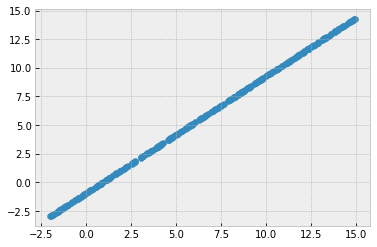

In [15]:
plt.scatter(X_test, y_pred.mean.asnumpy(), label = 'Prediction')
plt.plot(X_test,y_pred.mean.asnumpy()+2*y_pred.scale.asnumpy(),'g')
plt.plot(X_test,y_pred.mean.asnumpy()-2*y_pred.scale.asnumpy(),'g')
plt.scatter(X_test, y_test, label = 'Original data')
plt.legend()

In [16]:
y_pred.mean


[ 2.2621927   0.7503408   1.636599   11.037883    2.557612    7.2321877
  4.973099    3.2005835   3.7740445   9.838828   11.993651    7.1626773
 13.24484    -2.4471388   3.1484509   1.2021586   7.857782   -0.8483989
  1.6713542   3.0615625  -0.10116184  3.3048491  -1.9779433  12.202183
 11.872008   -2.2907403   8.657151    1.0110049  -1.9431881  -1.3349719
  7.475475    6.8672585  11.420191   -0.3096931   7.423342    1.7234868
 11.680855   -1.4044824   7.840404    6.623972    2.175305    6.1373987
 -0.11853945  0.31590068  4.225862    6.64135     4.0694637  -1.7867897
  7.701383   14.183229   12.410715    9.97785     8.292222    1.3064243
 12.497602    8.326977   10.325401    5.0426097   7.9099145   5.007855
  2.731388    4.8862114  10.447045   13.366483   13.627147   13.192706
  1.1152707  -2.5514045   7.4928527   4.5212817  -1.0569302  -2.082209
  0.36803353  8.88306    14.009454   14.200608    5.6508265   5.8072243
  6.3806853   3.2179613  11.698232    9.5260315   0.19425738 10.950